In [23]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from googletrans import Translator
from langdetect import detect, DetectorFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [ ]:
# Set seed for langdetect
DetectorFactory.seed = 0

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')

# Load the Dataset
print("Loading dataset...")
df = pd.read_csv('strangerThing.csv', encoding='ISO-8859-1', on_bad_lines='skip', quotechar='"')
print(f"Initial dataset shape: {df.shape}")
print(df.head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Loading dataset...
Initial dataset shape: (100000, 4)
                        Date           User  \
0  2022-07-01 23:59:59+00:00      sshuasite   
1  2022-07-01 23:59:59+00:00      UrFav3laa   
2  2022-07-01 23:59:59+00:00      LukeRoy26   
3  2022-07-01 23:59:59+00:00  Morgane_Stark   
4  2022-07-01 23:59:59+00:00      Verlaxify   

                                               Tweet Language  
0       no quiero ver stranger things m da miedo nia       es  
1  ÙØ±Ø¨Ù Ø§Ù Ø§ÙØ¹Ø¸ÙØ© Ø¯Ù Ø¨Ø¬Ø¯ Ø§Ø®Ø± ...       ar  
2  *SPOILERS*\n#StrangerThings was awesome first ...       en  
3                       Jâai fini Stranger Things.       fr  
4  STRANGER THINGS IS AMAZING!!! #StrangerThings4...       en  


In [ ]:
# Rename columns to match the expected format
df.columns = ['date', 'username', 'review', 'language']
print("\nColumns renamed:")
print(df.head())

# Handle Missing Data
print("\nHandling missing data...")
initial_shape = df.shape
df.dropna(subset=['review'], inplace=True)
print(f"Dropped rows with missing reviews. Shape changed from {initial_shape} to {df.shape}")



Columns renamed:
                        date       username  \
0  2022-07-01 23:59:59+00:00      sshuasite   
1  2022-07-01 23:59:59+00:00      UrFav3laa   
2  2022-07-01 23:59:59+00:00      LukeRoy26   
3  2022-07-01 23:59:59+00:00  Morgane_Stark   
4  2022-07-01 23:59:59+00:00      Verlaxify   

                                              review language  
0       no quiero ver stranger things m da miedo nia       es  
1  ÙØ±Ø¨Ù Ø§Ù Ø§ÙØ¹Ø¸ÙØ© Ø¯Ù Ø¨Ø¬Ø¯ Ø§Ø®Ø± ...       ar  
2  *SPOILERS*\n#StrangerThings was awesome first ...       en  
3                       Jâai fini Stranger Things.       fr  
4  STRANGER THINGS IS AMAZING!!! #StrangerThings4...       en  

Handling missing data...
Dropped rows with missing reviews. Shape changed from (100000, 4) to (100000, 4)


In [ ]:
# Translate reviews to English
translator = Translator()

def translate_to_english(text):
    try:
        detected_lang = detect(text)
        if detected_lang != 'en':
            translated = translator.translate(text, src=detected_lang, dest='en')
            return translated.text
        else:
            return text
    except:
        return text  # Return the original text if translation fails

print("\nTranslating reviews to English...")
df['review'] = df['review'].apply(translate_to_english)
print("Translation completed:")
print(df[['review']].head())


Translating reviews to English...
Translation completed:
                                              review
0       no quiero ver stranger things m da miedo nia
1  ÙØ±Ø¨Ù Ø§Ù Ø§ÙØ¹Ø¸ÙØ© Ø¯Ù Ø¨Ø¬Ø¯ Ø§Ø®Ø± ...
2  *SPOILERS*\n#StrangerThings was awesome first ...
3                       Jâai fini Stranger Things.
4  STRANGER THINGS IS AMAZING!!! #StrangerThings4...


In [ ]:
# Save the translated reviews to a new CSV file
output_csv_path = 'translated_reviews.csv'
df.to_csv(output_csv_path, index=False)
print(f"Translated data saved to {output_csv_path}")

Translated data saved to translated_reviews.csv


In [ ]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')

# Load the translated reviews dataset
print("Loading translated dataset...")
df = pd.read_csv('translated_reviews.csv')
print(f"Translated dataset shape: {df.shape}")
print(df.head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Loading translated dataset...
Translated dataset shape: (28098, 6)
                        date       username  \
0  2022-07-01 23:59:59+00:00      LukeRoy26   
1  2022-07-01 23:59:59+00:00      Verlaxify   
2  2022-07-01 23:59:58+00:00  fatbitchdaddy   
3  2022-07-01 23:59:58+00:00   syd_baldwin_   
4  2022-07-01 23:59:56+00:00       nyuuyear   

                                              review language  \
0  *SPOILERS*\n#StrangerThings was awesome first ...       en   
1  STRANGER THINGS IS AMAZING!!! #StrangerThings4...       en   
2  @thesajeallen donât watch stranger things bu...       en   
3  bro some of us have jobs can I get a second to...       en   
4  Stranger Things SPOILERS!! pt.2\n*\n*\n*\nMy o...       en   

                                    review_processed     Label  
0  spoiler strangerthings awesome first think sil...  Positive  
1  stranger thing amazing strangerthings stangert...  Positive  
2  thesajeallen donât watch stranger thing heâs k...  Negative  

In [ ]:
# Text Preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Lowercase text
    text = text.lower()
    # Handle negations
    text = re.sub(r"\b(n't)\b", ' not', text)
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords and apply lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

print("\nPreprocessing text...")
df['review_processed'] = df['review'].apply(preprocess_text)
print("Text preprocessing completed:")
print(df[['review', 'review_processed']].head())


Preprocessing text...
Text preprocessing completed:
                                              review  \
0  *SPOILERS*\n#StrangerThings was awesome first ...   
1  STRANGER THINGS IS AMAZING!!! #StrangerThings4...   
2  @thesajeallen donât watch stranger things bu...   
3  bro some of us have jobs can I get a second to...   
4  Stranger Things SPOILERS!! pt.2\n*\n*\n*\nMy o...   

                                    review_processed  
0  spoiler strangerthings awesome first think sil...  
1  stranger thing amazing strangerthings stangert...  
2  thesajeallen donât watch stranger thing heâs k...  
3  bro u job get second watch new stranger thing ...  
4  stranger thing spoiler pt problem think right ...  


In [ ]:
# Lexicon-based Sentiment Analysis using VADER
sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    score = sia.polarity_scores(text)
    if score['compound'] >= 0.05:
        return 'Positive'
    elif score['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

print("\nPerforming sentiment analysis...")
df['Label'] = df['review_processed'].apply(get_sentiment)
print("Sentiment analysis completed:")
print(df['Label'].value_counts())


Performing sentiment analysis...
Sentiment analysis completed:
Label
Positive    14902
Negative    13196
Name: count, dtype: int64


In [ ]:
# Filter out 'Neutral' ratings for binary classification
print("\nFiltering out 'Neutral' sentiments...")
initial_shape = df.shape
df = df[df['Label'] != 'Neutral']
print(f"Filtered dataset shape from {initial_shape} to {df.shape}")
print(df['Label'].value_counts())


Filtering out 'Neutral' sentiments...
Filtered dataset shape from (28098, 6) to (28098, 6)
Label
Positive    14902
Negative    13196
Name: count, dtype: int64



Generating word cloud...


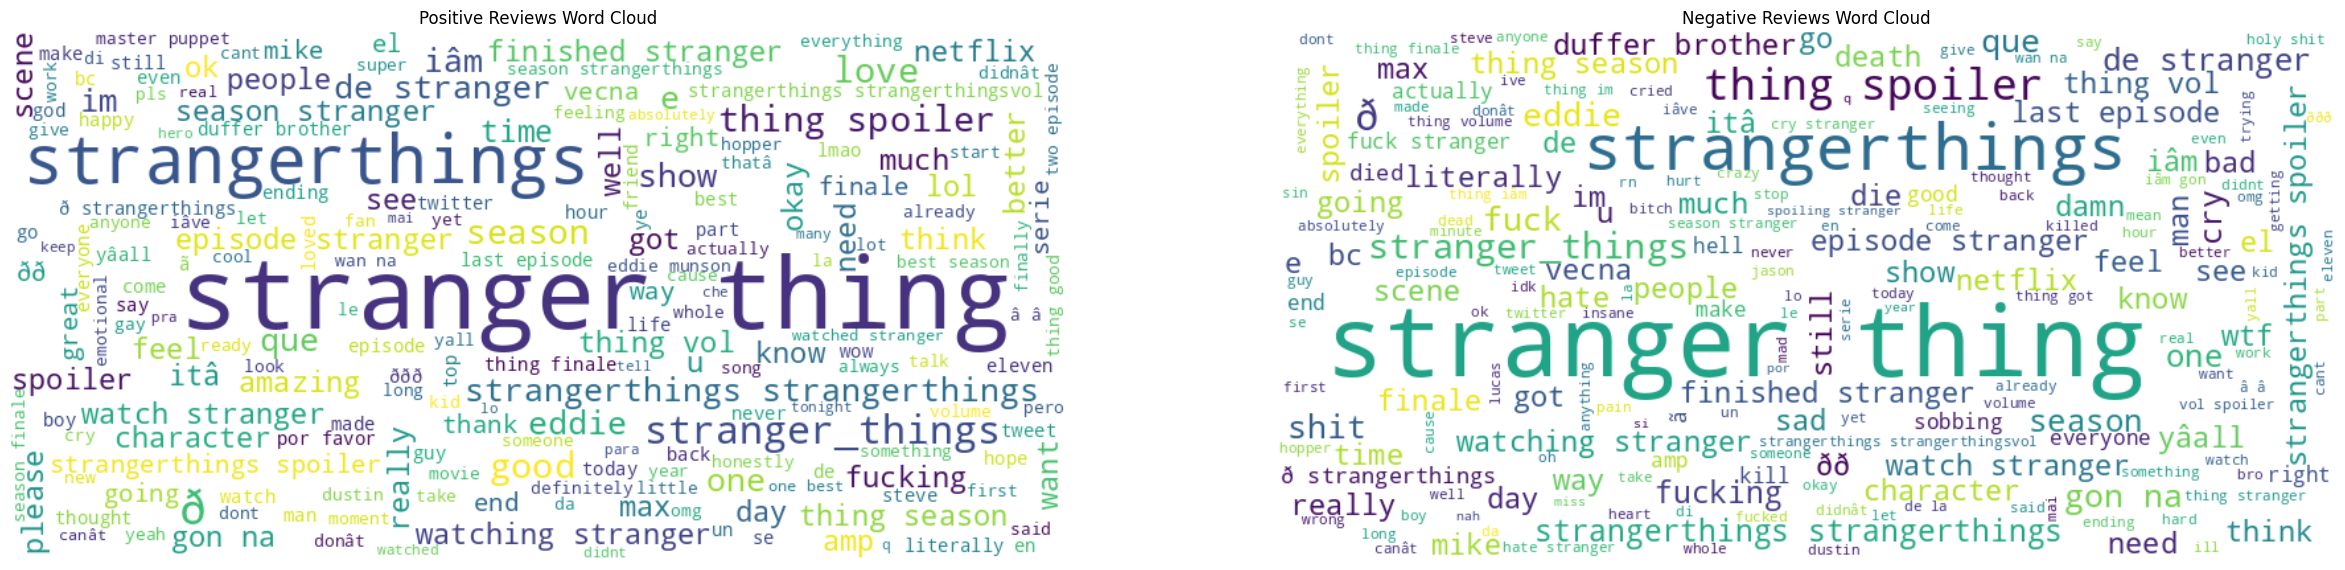

In [29]:
# Generate Word Cloud for Positive and Negative Reviews
from wordcloud import WordCloud
import matplotlib.pyplot as plt
print("\nGenerating word cloud...")
positive_text = ' '.join(df[df['Label'] == 'Positive']['review_processed'])
negative_text = ' '.join(df[df['Label'] == 'Negative']['review_processed'])

wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

plt.figure(figsize=(30, 12))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title('Positive Reviews Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title('Negative Reviews Word Cloud')
plt.axis('off')
plt.show()

In [ ]:
# Split the Data
print("\nSplitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(df['review_processed'], df['Label'], test_size=0.20, random_state=0, stratify=df['Label'])
print(f"Training set size: {X_train.shape[0]}, Testing set size: {X_test.shape[0]}")


Splitting data into training and testing sets...
Training set size: 22478, Testing set size: 5620


In [ ]:
# Vectorize the Text Data
print("\nVectorizing text data...")
tfidf_vectorizer = TfidfVectorizer()
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)
print("Vectorization completed.")


Vectorizing text data...
Vectorization completed.


In [ ]:
# Apply SMOTE to balance the training data
print("\nApplying SMOTE to balance the training data...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(tfidf_train, y_train)
print(f"SMOTE applied. New training set size: {X_train_smote.shape[0]}")


Applying SMOTE to balance the training data...
SMOTE applied. New training set size: 23842


In [ ]:
# Train Naive Bayes Model
print("\nTraining Naive Bayes model...")
nb = MultinomialNB()
nb.fit(X_train_smote, y_train_smote)
print("Naive Bayes model training completed.")


Training Naive Bayes model...
Naive Bayes model training completed.


In [ ]:
# Model Evaluation Function
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label='Negative')
    recall = recall_score(y_test, y_pred, pos_label='Negative')
    f1 = f1_score(y_test, y_pred, pos_label='Negative')

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

In [ ]:
# Evaluate Naive Bayes
print("\nEvaluating Naive Bayes model...")
evaluate_model(nb, tfidf_test, y_test)


Evaluating Naive Bayes model...
Accuracy: 0.8599644128113879
Precision: 0.840691685062546
Recall: 0.8658582796513831
F1 Score: 0.8530894157177524

Confusion Matrix:
 [[2285  354]
 [ 433 2548]]

Classification Report:
               precision    recall  f1-score   support

    Negative       0.84      0.87      0.85      2639
    Positive       0.88      0.85      0.87      2981

    accuracy                           0.86      5620
   macro avg       0.86      0.86      0.86      5620
weighted avg       0.86      0.86      0.86      5620



In [ ]:
# Predict sentiment of new text
def predict_sentiment(text):
    text_processed = preprocess_text(text)
    text_vectorized = tfidf_vectorizer.transform([text_processed])
    prediction = nb.predict(text_vectorized)
    return prediction[0]

In [ ]:
# User input for new review sentiment prediction
while True:
    new_review = input("\nEnter a review to predict its sentiment (or type 'exit' to quit): ")
    if new_review.lower() == 'exit':
        break
    sentiment = predict_sentiment(new_review)
    print(f"Predicted sentiment: {sentiment}")


Enter a review to predict its sentiment (or type 'exit' to quit): ITS SO BAD
Predicted sentiment: Negative

Enter a review to predict its sentiment (or type 'exit' to quit): OH MY GOD!! IM SO EXCITING
Predicted sentiment: Positive

Enter a review to predict its sentiment (or type 'exit' to quit): BAD BOY!!
Predicted sentiment: Negative

Enter a review to predict its sentiment (or type 'exit' to quit): ITS GETTING WORSE
Predicted sentiment: Negative

Enter a review to predict its sentiment (or type 'exit' to quit): ITS GETTING GOOD NOW! HAHA!
Predicted sentiment: Positive

Enter a review to predict its sentiment (or type 'exit' to quit): exit


In [ ]:
#Save Model for Deployment
import joblib
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from googletrans import Translator
from langdetect import detect, DetectorFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# Save the model and vectorizer
print("\nSaving the model and vectorizer...")
joblib.dump(nb.fit, 'naive_bayes_model.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
print("Model and vectorizer saved successfully.")


Saving the model and vectorizer...
Model and vectorizer saved successfully.
